In [276]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import optim

In [277]:
# get transform
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# get data
download_root = './sample_data'
train_dataset = datasets.MNIST(download_root, transform=mnist_transform, train=True, download=True)
test_dataset = datasets.MNIST(download_root, transform=mnist_transform, train=False, download=True)

# get dataloader
batch_size = 256
train_loader = DataLoader(dataset=train_dataset,
                         batch_size=batch_size,
                         shuffle=True)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=True)

# plt.imshow(torch.Tensor(train_dataset[0][0]).permute(1,2,0).detach().numpy(), cmap='gray')

In [278]:
class MLP(nn.Module):
  def __init__(self, regularizer_type: str, train_loader, test_loader, _lambda=1e-4):
    super().__init__()

    if regularizer_type == 'l1':
      self._lambda = _lambda
      self.norm = 1

    if regularizer_type == 'l2':
      self._lambda = _lambda
      self.norm = 2

    if regularizer_type == 'l3':
      self._lambda = _lambda
      self.norm = 3

    self.train_loader = train_loader
    self.test_loader = test_loader

    self.mlp = nn.Sequential(
      nn.Linear(28*28*1, 100),
      nn.ReLU(),
      nn.Linear(100, 100),
      nn.ReLU(),
      nn.Linear(100, 10)
    )

    self.loss = nn.CrossEntropyLoss()
    self.optimizer = optim.Adam(self.mlp.parameters(), lr=0.01)

  def forward(self, x):
    b,c,h,w = x.shape
    input = x.view(b,c*h*w)

    # network
    output = self.mlp(input)

    return output

  def get_weight(self):
    return self.mlp[0].weight

  def get_loss(self, output, label):
    first_layer_weight = self.get_weight()
    loss = self.loss(output, label) + self._lambda * torch.norm(first_layer_weight, self.norm)
    return loss

  def train(self, epochs, save):
    self.test_accuracy_list=[]
    self.train_accuracy_list=[]

    self.mlp.train()
    for epoch in tqdm(range(epochs)):

      # train accuracy
      total_count=0
      incorrect_count=0

      for x, label in self.train_loader:
        self.optimizer.zero_grad()
        outputs = self(x)

        label_predict = torch.argmax(outputs.clone().detach(), dim=1)

        # check label_predict
        incorrect = (label_predict-label).count_nonzero()

        # update
        total_count += x.shape[0]
        incorrect_count += incorrect

        loss = self.get_loss(outputs, label)
        loss.backward()
        self.optimizer.step()

      if (epoch+1)%save == 0 or epoch == 0:
        self.show_weight_map(epoch)
      self.test()
      accuracy = float((total_count-incorrect_count)/total_count)
      self.train_accuracy_list.append(str(accuracy))
      print(f'Train Accuracy : {accuracy}')

    # save accuracy
    with open(f'./L{self.norm}_test_accuracy.txt', 'w') as f1:
      f1.write('\n'.join(self.test_accuracy_list))
    with open(f'./L{self.norm}_train_accuracy.txt', 'w') as f2:
      f2.write('\n'.join(self.train_accuracy_list))

  def test(self):
      total_count=0
      incorrect_count=0

      self.mlp.eval()
      with torch.no_grad():
        for x, label in self.test_loader:
          outputs = self(x)
          label_predict = torch.argmax(outputs, dim=1)

          # check label_predict
          incorrect = (label_predict-label).count_nonzero()

          # update
          total_count += x.shape[0]
          incorrect_count += incorrect

      accuracy = float((total_count-incorrect_count)/total_count)
      self.test_accuracy_list.append(str(accuracy))
      print(f'\nTest Accuracy : {accuracy}')
      self.mlp.train()

  def show_weight_map(self, epoch):
    w = self.get_weight()
    w = torch.mean(w, dim=0)
    # print(f'\n MAX : {w.max()}, MIN : {w.min()}')
    norm_w = torch.abs(w/torch.abs(w).max())
    image = np.repeat(norm_w.view(28,28,1).detach().numpy(),3,-1)

    # upscale image
    scale = 50
    new_image = np.zeros((image.shape[0]*scale, image.shape[1]*scale, image.shape[2]))

    for i in range(image.shape[0]):
      for j in range(image.shape[1]):
        new_image[i*scale:(i+1)*scale, j*scale:(j+1)*scale] = image[i,j]

    plt.axis('off')
    plt.imsave(f'L{self.norm}_weight_{epoch}.png', new_image, cmap='gray')
    plt.imshow(image, cmap='gray')

  1%|          | 1/100 [00:18<30:59, 18.78s/it]


Test Accuracy : 0.9186000227928162
Train Accuracy : 0.864549994468689


  2%|▏         | 2/100 [00:36<29:49, 18.26s/it]


Test Accuracy : 0.9402999877929688
Train Accuracy : 0.933566689491272


  3%|▎         | 3/100 [00:55<29:40, 18.35s/it]


Test Accuracy : 0.9480000138282776
Train Accuracy : 0.9416833519935608


  4%|▍         | 4/100 [01:12<28:59, 18.12s/it]


Test Accuracy : 0.9358000159263611
Train Accuracy : 0.9461833238601685


  5%|▌         | 5/100 [01:31<28:59, 18.31s/it]


Test Accuracy : 0.9441999793052673
Train Accuracy : 0.947433352470398


  6%|▌         | 6/100 [01:49<28:39, 18.29s/it]


Test Accuracy : 0.949999988079071
Train Accuracy : 0.9507833123207092


  7%|▋         | 7/100 [02:07<27:59, 18.06s/it]


Test Accuracy : 0.9474999904632568
Train Accuracy : 0.9488333463668823


  8%|▊         | 8/100 [02:26<28:00, 18.27s/it]


Test Accuracy : 0.9610000252723694
Train Accuracy : 0.953416645526886


  9%|▉         | 9/100 [02:43<27:23, 18.06s/it]


Test Accuracy : 0.9503999948501587
Train Accuracy : 0.9508666396141052


 10%|█         | 10/100 [03:01<26:57, 17.98s/it]


Test Accuracy : 0.9487000107765198
Train Accuracy : 0.9513999819755554


 11%|█         | 11/100 [03:20<27:00, 18.21s/it]


Test Accuracy : 0.9354000091552734
Train Accuracy : 0.9521833062171936


 12%|█▏        | 12/100 [03:37<26:22, 17.98s/it]


Test Accuracy : 0.9557999968528748
Train Accuracy : 0.9553333520889282


 13%|█▎        | 13/100 [03:56<26:19, 18.16s/it]


Test Accuracy : 0.9451000094413757
Train Accuracy : 0.9560999870300293


 14%|█▍        | 14/100 [04:14<25:58, 18.12s/it]


Test Accuracy : 0.9484000205993652
Train Accuracy : 0.9536499977111816


 15%|█▌        | 15/100 [04:31<25:29, 17.99s/it]


Test Accuracy : 0.9510999917984009
Train Accuracy : 0.9545000195503235


 16%|█▌        | 16/100 [04:50<25:29, 18.20s/it]


Test Accuracy : 0.948199987411499
Train Accuracy : 0.9568833112716675


 17%|█▋        | 17/100 [05:08<24:55, 18.02s/it]


Test Accuracy : 0.9449999928474426
Train Accuracy : 0.9567166566848755


 18%|█▊        | 18/100 [05:26<24:32, 17.96s/it]


Test Accuracy : 0.9366999864578247
Train Accuracy : 0.956333339214325


 19%|█▉        | 19/100 [05:44<24:28, 18.13s/it]


Test Accuracy : 0.9093000292778015
Train Accuracy : 0.9559333324432373


 20%|██        | 20/100 [06:02<24:01, 18.02s/it]


Test Accuracy : 0.9602000117301941
Train Accuracy : 0.9532166719436646


 21%|██        | 21/100 [06:21<23:59, 18.23s/it]


Test Accuracy : 0.9527000188827515
Train Accuracy : 0.9585833549499512


 22%|██▏       | 22/100 [06:38<23:26, 18.03s/it]


Test Accuracy : 0.9435999989509583
Train Accuracy : 0.9546833038330078


 23%|██▎       | 23/100 [06:56<22:58, 17.91s/it]


Test Accuracy : 0.9358999729156494
Train Accuracy : 0.9583333134651184


 24%|██▍       | 24/100 [07:14<22:59, 18.15s/it]


Test Accuracy : 0.9550999999046326
Train Accuracy : 0.9563666582107544


 25%|██▌       | 25/100 [07:32<22:28, 17.99s/it]


Test Accuracy : 0.9506999850273132
Train Accuracy : 0.9545333385467529


 26%|██▌       | 26/100 [07:50<22:15, 18.05s/it]


Test Accuracy : 0.9574000239372253
Train Accuracy : 0.9558833241462708


 27%|██▋       | 27/100 [08:08<21:53, 17.99s/it]


Test Accuracy : 0.95660001039505
Train Accuracy : 0.9575999975204468


 28%|██▊       | 28/100 [08:25<21:21, 17.80s/it]


Test Accuracy : 0.9538000226020813
Train Accuracy : 0.9584166407585144


 29%|██▉       | 29/100 [08:44<21:23, 18.07s/it]


Test Accuracy : 0.9538999795913696
Train Accuracy : 0.9587833285331726


 30%|███       | 30/100 [09:02<20:59, 18.00s/it]


Test Accuracy : 0.9361000061035156
Train Accuracy : 0.9578666687011719


 31%|███       | 31/100 [09:20<20:32, 17.87s/it]


Test Accuracy : 0.9351999759674072
Train Accuracy : 0.9579166769981384


 32%|███▏      | 32/100 [09:38<20:31, 18.10s/it]


Test Accuracy : 0.9531999826431274
Train Accuracy : 0.9566166400909424


 33%|███▎      | 33/100 [09:56<20:00, 17.91s/it]


Test Accuracy : 0.9506000280380249
Train Accuracy : 0.9556333422660828


 34%|███▍      | 34/100 [10:14<19:52, 18.07s/it]


Test Accuracy : 0.9473999738693237
Train Accuracy : 0.9567166566848755


 35%|███▌      | 35/100 [10:32<19:29, 17.99s/it]


Test Accuracy : 0.947700023651123
Train Accuracy : 0.9580666422843933


 36%|███▌      | 36/100 [10:49<19:02, 17.86s/it]


Test Accuracy : 0.954800009727478
Train Accuracy : 0.9545999765396118


 37%|███▋      | 37/100 [11:08<19:02, 18.14s/it]


Test Accuracy : 0.9575999975204468
Train Accuracy : 0.9553666710853577


 38%|███▊      | 38/100 [11:26<18:38, 18.04s/it]


Test Accuracy : 0.9427000284194946
Train Accuracy : 0.9565333127975464


 39%|███▉      | 39/100 [11:44<18:12, 17.92s/it]


Test Accuracy : 0.9634000062942505
Train Accuracy : 0.9559166431427002


 40%|████      | 40/100 [12:02<18:06, 18.11s/it]


Test Accuracy : 0.9524000287055969
Train Accuracy : 0.9596499800682068


 41%|████      | 41/100 [12:20<17:41, 17.98s/it]


Test Accuracy : 0.9537000060081482
Train Accuracy : 0.9580166935920715


 42%|████▏     | 42/100 [12:39<17:34, 18.19s/it]


Test Accuracy : 0.946399986743927
Train Accuracy : 0.9594833254814148


 43%|████▎     | 43/100 [12:56<17:07, 18.03s/it]


Test Accuracy : 0.9524999856948853
Train Accuracy : 0.9590833187103271


 44%|████▍     | 44/100 [13:14<16:42, 17.90s/it]


Test Accuracy : 0.9276999831199646
Train Accuracy : 0.956250011920929


 45%|████▌     | 45/100 [13:33<16:38, 18.16s/it]


Test Accuracy : 0.9433000087738037
Train Accuracy : 0.9537000060081482


 46%|████▌     | 46/100 [13:50<16:14, 18.04s/it]


Test Accuracy : 0.9490000009536743
Train Accuracy : 0.9581666588783264


 47%|████▋     | 47/100 [14:09<16:01, 18.14s/it]


Test Accuracy : 0.9589999914169312
Train Accuracy : 0.9599999785423279


 48%|████▊     | 48/100 [14:27<15:38, 18.05s/it]


Test Accuracy : 0.9570000171661377
Train Accuracy : 0.9587166905403137


 49%|████▉     | 49/100 [14:44<15:12, 17.89s/it]


Test Accuracy : 0.9406999945640564
Train Accuracy : 0.9576666951179504


 50%|█████     | 50/100 [15:03<15:08, 18.18s/it]


Test Accuracy : 0.9527999758720398
Train Accuracy : 0.9595999717712402


 51%|█████     | 51/100 [15:21<14:41, 17.99s/it]


Test Accuracy : 0.9516000151634216
Train Accuracy : 0.9578166604042053


 52%|█████▏    | 52/100 [15:38<14:20, 17.92s/it]


Test Accuracy : 0.9587000012397766
Train Accuracy : 0.9581166505813599


 53%|█████▎    | 53/100 [15:56<14:05, 18.00s/it]


Test Accuracy : 0.9552000164985657
Train Accuracy : 0.9616666436195374


 54%|█████▍    | 54/100 [16:14<13:41, 17.86s/it]


Test Accuracy : 0.9611999988555908
Train Accuracy : 0.9590499997138977


 55%|█████▌    | 55/100 [16:33<13:32, 18.05s/it]


Test Accuracy : 0.9496999979019165
Train Accuracy : 0.956683337688446


 56%|█████▌    | 56/100 [16:50<13:11, 17.98s/it]


Test Accuracy : 0.9613000154495239
Train Accuracy : 0.956333339214325


 57%|█████▋    | 57/100 [17:08<12:47, 17.86s/it]


Test Accuracy : 0.9527000188827515
Train Accuracy : 0.9578333497047424


 58%|█████▊    | 58/100 [17:27<12:39, 18.09s/it]


Test Accuracy : 0.9563999772071838
Train Accuracy : 0.956250011920929


 59%|█████▉    | 59/100 [17:44<12:15, 17.93s/it]


Test Accuracy : 0.9509000182151794
Train Accuracy : 0.9585666656494141


 60%|██████    | 60/100 [18:02<11:58, 17.96s/it]


Test Accuracy : 0.954800009727478
Train Accuracy : 0.9589333534240723


 61%|██████    | 61/100 [18:20<11:42, 18.00s/it]


Test Accuracy : 0.9545999765396118
Train Accuracy : 0.9592000246047974


 62%|██████▏   | 62/100 [18:38<11:21, 17.93s/it]


Test Accuracy : 0.9508000016212463
Train Accuracy : 0.9563000202178955


 63%|██████▎   | 63/100 [18:57<11:09, 18.11s/it]


Test Accuracy : 0.9628000259399414
Train Accuracy : 0.961899995803833


 64%|██████▍   | 64/100 [19:14<10:48, 18.00s/it]


Test Accuracy : 0.9448000192642212
Train Accuracy : 0.9582499861717224


 65%|██████▌   | 65/100 [19:32<10:29, 18.00s/it]


Test Accuracy : 0.9621999859809875
Train Accuracy : 0.9576333165168762


 66%|██████▌   | 66/100 [19:51<10:18, 18.19s/it]


Test Accuracy : 0.9508000016212463
Train Accuracy : 0.9588833451271057


 67%|██████▋   | 67/100 [20:09<09:55, 18.04s/it]


Test Accuracy : 0.9502000212669373
Train Accuracy : 0.9610166549682617


 68%|██████▊   | 68/100 [20:27<09:43, 18.24s/it]


Test Accuracy : 0.9611999988555908
Train Accuracy : 0.9570500254631042


 69%|██████▉   | 69/100 [20:45<09:19, 18.05s/it]


Test Accuracy : 0.953000009059906
Train Accuracy : 0.9585666656494141


 70%|███████   | 70/100 [21:03<08:59, 17.99s/it]


Test Accuracy : 0.9581000208854675
Train Accuracy : 0.9550999999046326


 71%|███████   | 71/100 [21:22<08:48, 18.23s/it]


Test Accuracy : 0.9577000141143799
Train Accuracy : 0.9623333215713501


 72%|███████▏  | 72/100 [21:39<08:27, 18.13s/it]


Test Accuracy : 0.9580000042915344
Train Accuracy : 0.9554666876792908


 73%|███████▎  | 73/100 [21:57<08:08, 18.09s/it]


Test Accuracy : 0.9546999931335449
Train Accuracy : 0.962233304977417


 74%|███████▍  | 74/100 [22:16<07:51, 18.12s/it]


Test Accuracy : 0.9531000256538391
Train Accuracy : 0.9576500058174133


 75%|███████▌  | 75/100 [22:33<07:28, 17.93s/it]


Test Accuracy : 0.9542999863624573
Train Accuracy : 0.9597499966621399


 76%|███████▌  | 76/100 [22:52<07:15, 18.15s/it]


Test Accuracy : 0.9592000246047974
Train Accuracy : 0.9577000141143799


 77%|███████▋  | 77/100 [23:09<06:53, 17.98s/it]


Test Accuracy : 0.9588000178337097
Train Accuracy : 0.9606333374977112


 78%|███████▊  | 78/100 [23:27<06:33, 17.90s/it]


Test Accuracy : 0.9569000005722046
Train Accuracy : 0.9575666785240173


 79%|███████▉  | 79/100 [23:46<06:21, 18.16s/it]


Test Accuracy : 0.9571999907493591
Train Accuracy : 0.9556499719619751


 80%|████████  | 80/100 [24:04<06:01, 18.07s/it]


Test Accuracy : 0.9577999711036682
Train Accuracy : 0.9589833617210388


 81%|████████  | 81/100 [24:22<05:44, 18.14s/it]


Test Accuracy : 0.9563000202178955
Train Accuracy : 0.9564999938011169


 82%|████████▏ | 82/100 [24:40<05:26, 18.15s/it]


Test Accuracy : 0.9555000066757202
Train Accuracy : 0.9599166512489319


 83%|████████▎ | 83/100 [24:58<05:05, 17.99s/it]


Test Accuracy : 0.9585000276565552
Train Accuracy : 0.9638000130653381


 84%|████████▍ | 84/100 [25:16<04:50, 18.15s/it]


Test Accuracy : 0.9498000144958496
Train Accuracy : 0.9577500224113464


 85%|████████▌ | 85/100 [25:34<04:30, 18.05s/it]


Test Accuracy : 0.9573000073432922
Train Accuracy : 0.9539166688919067


 86%|████████▌ | 86/100 [25:52<04:12, 18.01s/it]


Test Accuracy : 0.9424999952316284
Train Accuracy : 0.9593999981880188


 87%|████████▋ | 87/100 [26:11<03:56, 18.18s/it]


Test Accuracy : 0.9574999809265137
Train Accuracy : 0.954883337020874


 88%|████████▊ | 88/100 [26:28<03:35, 17.99s/it]


Test Accuracy : 0.9560999870300293
Train Accuracy : 0.9590833187103271


 89%|████████▉ | 89/100 [26:47<03:19, 18.10s/it]


Test Accuracy : 0.9523000121116638
Train Accuracy : 0.9563000202178955


 90%|█████████ | 90/100 [27:05<03:01, 18.12s/it]


Test Accuracy : 0.9617999792098999
Train Accuracy : 0.9593833088874817


 91%|█████████ | 91/100 [27:22<02:41, 17.98s/it]


Test Accuracy : 0.9541000127792358
Train Accuracy : 0.9591166377067566


 92%|█████████▏| 92/100 [27:41<02:25, 18.18s/it]


Test Accuracy : 0.9427000284194946
Train Accuracy : 0.9605833292007446


 93%|█████████▎| 93/100 [27:59<02:06, 18.07s/it]


Test Accuracy : 0.9542999863624573
Train Accuracy : 0.9628166556358337


 94%|█████████▍| 94/100 [28:17<01:49, 18.19s/it]


Test Accuracy : 0.9539999961853027
Train Accuracy : 0.9550333619117737


 95%|█████████▌| 95/100 [28:35<01:30, 18.07s/it]


Test Accuracy : 0.9550999999046326
Train Accuracy : 0.9609000086784363


 96%|█████████▌| 96/100 [28:53<01:11, 17.98s/it]


Test Accuracy : 0.949400007724762
Train Accuracy : 0.9602166414260864


 97%|█████████▋| 97/100 [29:11<00:54, 18.17s/it]


Test Accuracy : 0.965499997138977
Train Accuracy : 0.9587833285331726


 98%|█████████▊| 98/100 [29:29<00:35, 17.97s/it]


Test Accuracy : 0.9538000226020813
Train Accuracy : 0.9580333232879639


 99%|█████████▉| 99/100 [29:47<00:17, 17.98s/it]


Test Accuracy : 0.9581000208854675
Train Accuracy : 0.9609833359718323


100%|██████████| 100/100 [30:06<00:00, 18.06s/it]


Test Accuracy : 0.9492999911308289
Train Accuracy : 0.9594666957855225


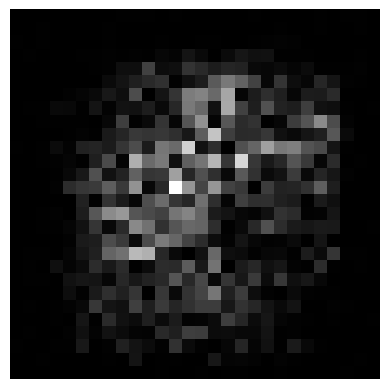

In [274]:
# define model
model_l1 = MLP(regularizer_type='l1', train_loader=train_loader, test_loader=test_loader)
# train
model_l1.train(epochs=100, save=10)

  1%|          | 1/100 [00:18<31:14, 18.93s/it]


Test Accuracy : 0.9286999702453613
Train Accuracy : 0.8688333630561829


  2%|▏         | 2/100 [00:36<29:24, 18.00s/it]


Test Accuracy : 0.9437000155448914
Train Accuracy : 0.9396666884422302


  3%|▎         | 3/100 [00:54<29:27, 18.22s/it]


Test Accuracy : 0.9498999714851379
Train Accuracy : 0.9505666494369507


  4%|▍         | 4/100 [01:11<28:30, 17.82s/it]


Test Accuracy : 0.9538999795913696
Train Accuracy : 0.9548333287239075


  5%|▌         | 5/100 [01:29<27:57, 17.66s/it]


Test Accuracy : 0.9555000066757202
Train Accuracy : 0.9565833210945129


  6%|▌         | 6/100 [01:47<27:57, 17.84s/it]


Test Accuracy : 0.9581999778747559
Train Accuracy : 0.9580000042915344


  6%|▌         | 6/100 [01:50<28:45, 18.36s/it]


KeyboardInterrupt: 

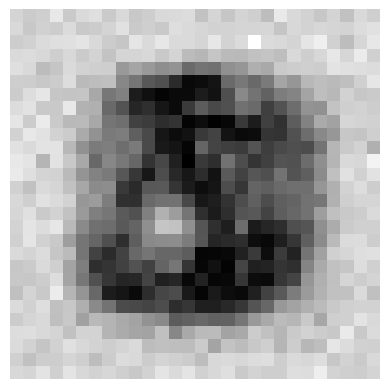

In [ ]:
# define model
model_l2 = MLP(regularizer_type='l2', train_loader=train_loader, test_loader=test_loader)
# train
model_l2.train(epochs=100, save=10)

In [ ]:
# define model
model_l3 = MLP(regularizer_type='l3', train_loader=train_loader, test_loader=test_loader)
# train
model_l3.train(epochs=100, save=10)